<a href="https://colab.research.google.com/github/roni762583/NEAT/blob/main/NEAT_FX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install neat-python
!pip install visualize==0.5.1

import neat
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# import local config file
from google.colab import files
uploaded = files.upload() 
config_file = list(uploaded.keys())[0]
# make sure pandas doesn’t hide any columns
pd.set_option("display.max.columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving config-feedforward to config-feedforward (1)


In [30]:
# import price data
!ls

from google.colab import files
uploaded = files.upload() 
filename = list(uploaded.keys())[0]
colnames=['TIME', 'bid', 'ask', 'tradable'] 
df = pd.read_csv(filename, names=colnames, header=None)
print(df.head())
print(df.dtypes)
df['datetime'] = pd.to_datetime( df['TIME'], format='%Y%m%d %H%M%S%f' )
df.head()
# Don't set datetime as index column to aid in label synthesis below
# df.set_index(df['datetime'], inplace = True)
# df.head
# drop extra columns
df.drop(['TIME','tradable'], axis=1, inplace=True) # keep 'datetime',
print("Shape: ",df.shape)
print(df.head())
print("count: ",df.count())

 config-feedforward	   DAT_ASCII_GBPUSD_T_201702.csv   sample_data
'config-feedforward (1)'   DAT_ASCII_GBPUSD_T_201704.csv


Saving DAT_ASCII_GBPUSD_T_201702.csv to DAT_ASCII_GBPUSD_T_201702 (1).csv
                 TIME      bid      ask  tradable
0  20170201 000000390  1.25726  1.25738         0
1  20170201 000000640  1.25728  1.25741         0
2  20170201 000002127  1.25726  1.25740         0
3  20170201 000002627  1.25725  1.25739         0
4  20170201 000003127  1.25727  1.25740         0
TIME         object
bid         float64
ask         float64
tradable      int64
dtype: object
Shape:  (1473353, 3)
       bid      ask                datetime
0  1.25726  1.25738 2017-02-01 00:00:00.390
1  1.25728  1.25741 2017-02-01 00:00:00.640
2  1.25726  1.25740 2017-02-01 00:00:02.127
3  1.25725  1.25739 2017-02-01 00:00:02.627
4  1.25727  1.25740 2017-02-01 00:00:03.127
count:  bid         1473353
ask         1473353
datetime    1473353
dtype: int64


In [31]:
# build Hull Moving Avg. as features of environment
def WMA(s, period):
       return s.rolling(period).apply(lambda x: ((np.arange(period)+1)*x).sum()/(np.arange(period)+1).sum(), raw=True)

def HMA(s, period):
       return WMA(WMA(s, period//2).multiply(2).sub(WMA(s, period)), int(np.sqrt(period)))

#df["hma5"] = HMA(df.bid, 5) # took >32 sec. to run on 1.08MM rows
#df['deltahma5'] = df.hma5.diff()
#df['deltahma5_5'] = df.hma5.diff(5)
#df['hma5hma5'] = HMA(df.hma5, 5)
#df['deltahma5hma5'] = df.hma5hma5.diff()
#df['deltahma5hma5_5'] = df.hma5hma5.diff(5) # divide by n+1 ticks to get avg. 
#df["hma20"] = HMA(df.bid, 20)
#df['bidhma20diff'] = df.bid - df.hma20
#df['bidhma50diff'] = df.bid - df.hma50

df['spread'] = df.ask - df.bid
# ma's
df['hma50'] = HMA(df.bid, 50)
df['hma200'] = HMA(df.bid, 200)
df['hma1000'] = HMA(df.bid, 1000)
df['hma5000'] = HMA(df.bid, 5000) # took 50 sec. to run this line

# log returns lr_
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

df['lr_hma50'] = log_return(HMA(df.bid, 50))
df['lr_hma200'] = log_return(HMA(df.bid, 200))
df['lr_hma1000'] = log_return(HMA(df.bid, 1000))
df['lr_hma5000'] = log_return(HMA(df.bid, 5000))
# ma momentums
df['mom10_hma50'] = df.hma50.diff(10)
df['mom10_hma200'] = df.hma200.diff(10)
df['mom10_hma1000'] = df.hma1000.diff(10)
df['mom10_hma5000'] = df.hma5000.diff(10)

# distance beteween ma's - take small period avg. minus large period
df['delta_hma50_hma5000'] = df.hma50 - df.hma5000
df['delta_hma50_hma200'] = df.hma50 - df.hma200
df['delta_hma200_hma1000'] = df.hma200 - df.hma1000
df['delta_hma1000_hma5000'] = df.hma1000 - df.hma5000
df['delta_hma200_hma5000'] = df.hma200 - df.hma5000

# get rid of NA rows
print('before removing Nans',df.count())
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print('after removing Nans',df.count())
# block can run for like 6 minutes

KeyboardInterrupt: ignored

In [15]:
df.head()

,bid,ask,spread,hma50,hma200,hma1000,hma5000,lr_hma50,lr_hma200,lr_hma1000,lr_hma5000,mom10_hma50,mom10_hma200,mom10_hma1000,mom10_hma5000,delta_hma50_hma5000,delta_hma50_hma200,delta_hma200_hma1000,delta_hma1000_hma5000,delta_hma200_hma5000
datetime,,,,,,,,,,,,,,,,,,,,
2017-04-02 21:53:00.027,1.25341,1.25350,0.00009,1.253370,1.253506,1.253484,1.253700,-0.000004,-0.000003,-7.501964e-07,-3.211065e-07,-0.000131,-0.000043,-0.000008,-0.000004,-0.000330,-0.000136,0.000022,-0.000216,-0.000194
2017-04-02 21:53:00.290,1.25347,1.25352,0.00005,1.253368,1.253502,1.253483,1.253700,-0.000002,-0.000003,-7.496065e-07,-3.228206e-07,-0.000117,-0.000044,-0.000008,-0.000004,-0.000332,-0.000134,0.000019,-0.000216,-0.000198
2017-04-02 21:53:00.527,1.25351,1.25360,0.00009,1.253369,1.253499,1.253483,1.253700,0.000001,-0.000003,-7.360521e-07,-3.233960e-07,-0.000099,-0.000043,-0.000009,-0.000004,-0.000330,-0.000130,0.000016,-0.000217,-0.000201
2017-04-02 21:53:04.777,1.25351,1.25361,0.00010,1.253373,1.253496,1.253482,1.253699,0.000003,-0.000002,-7.217401e-07,-3.239536e-07,-0.000079,-0.000042,-0.000009,-0.000004,-0.000326,-0.000123,0.000014,-0.000217,-0.000203
2017-04-02 21:53:06.777,1.25351,1.25359,0.00008,1.253379,1.253494,1.253481,1.253699,0.000005,-0.000002,-7.067667e-07,-3.244896e-07,-0.000056,-0.000040,-0.000009,-0.000004,-0.000320,-0.000115,0.000013,-0.000218,-0.000205


'\n# Ratio of MA differences to largest difference (between the two extreme ma periods)\naxs[15].plot(df.ratio_50delta200_tofullrange.iloc[rowsList])\naxs[15].set_title("ratio_50delta200_tofullrange")\n\naxs[16].plot(df.ratio_200delta1000_tofullrange.iloc[rowsList])\naxs[16].set_title("ratio_200delta1000_tofullrange")\n\naxs[17].plot(df.ratio_1000delta5000_tofullrange.iloc[rowsList])\naxs[17].set_title("ratio_1000delta5000_tofullrange")\n'

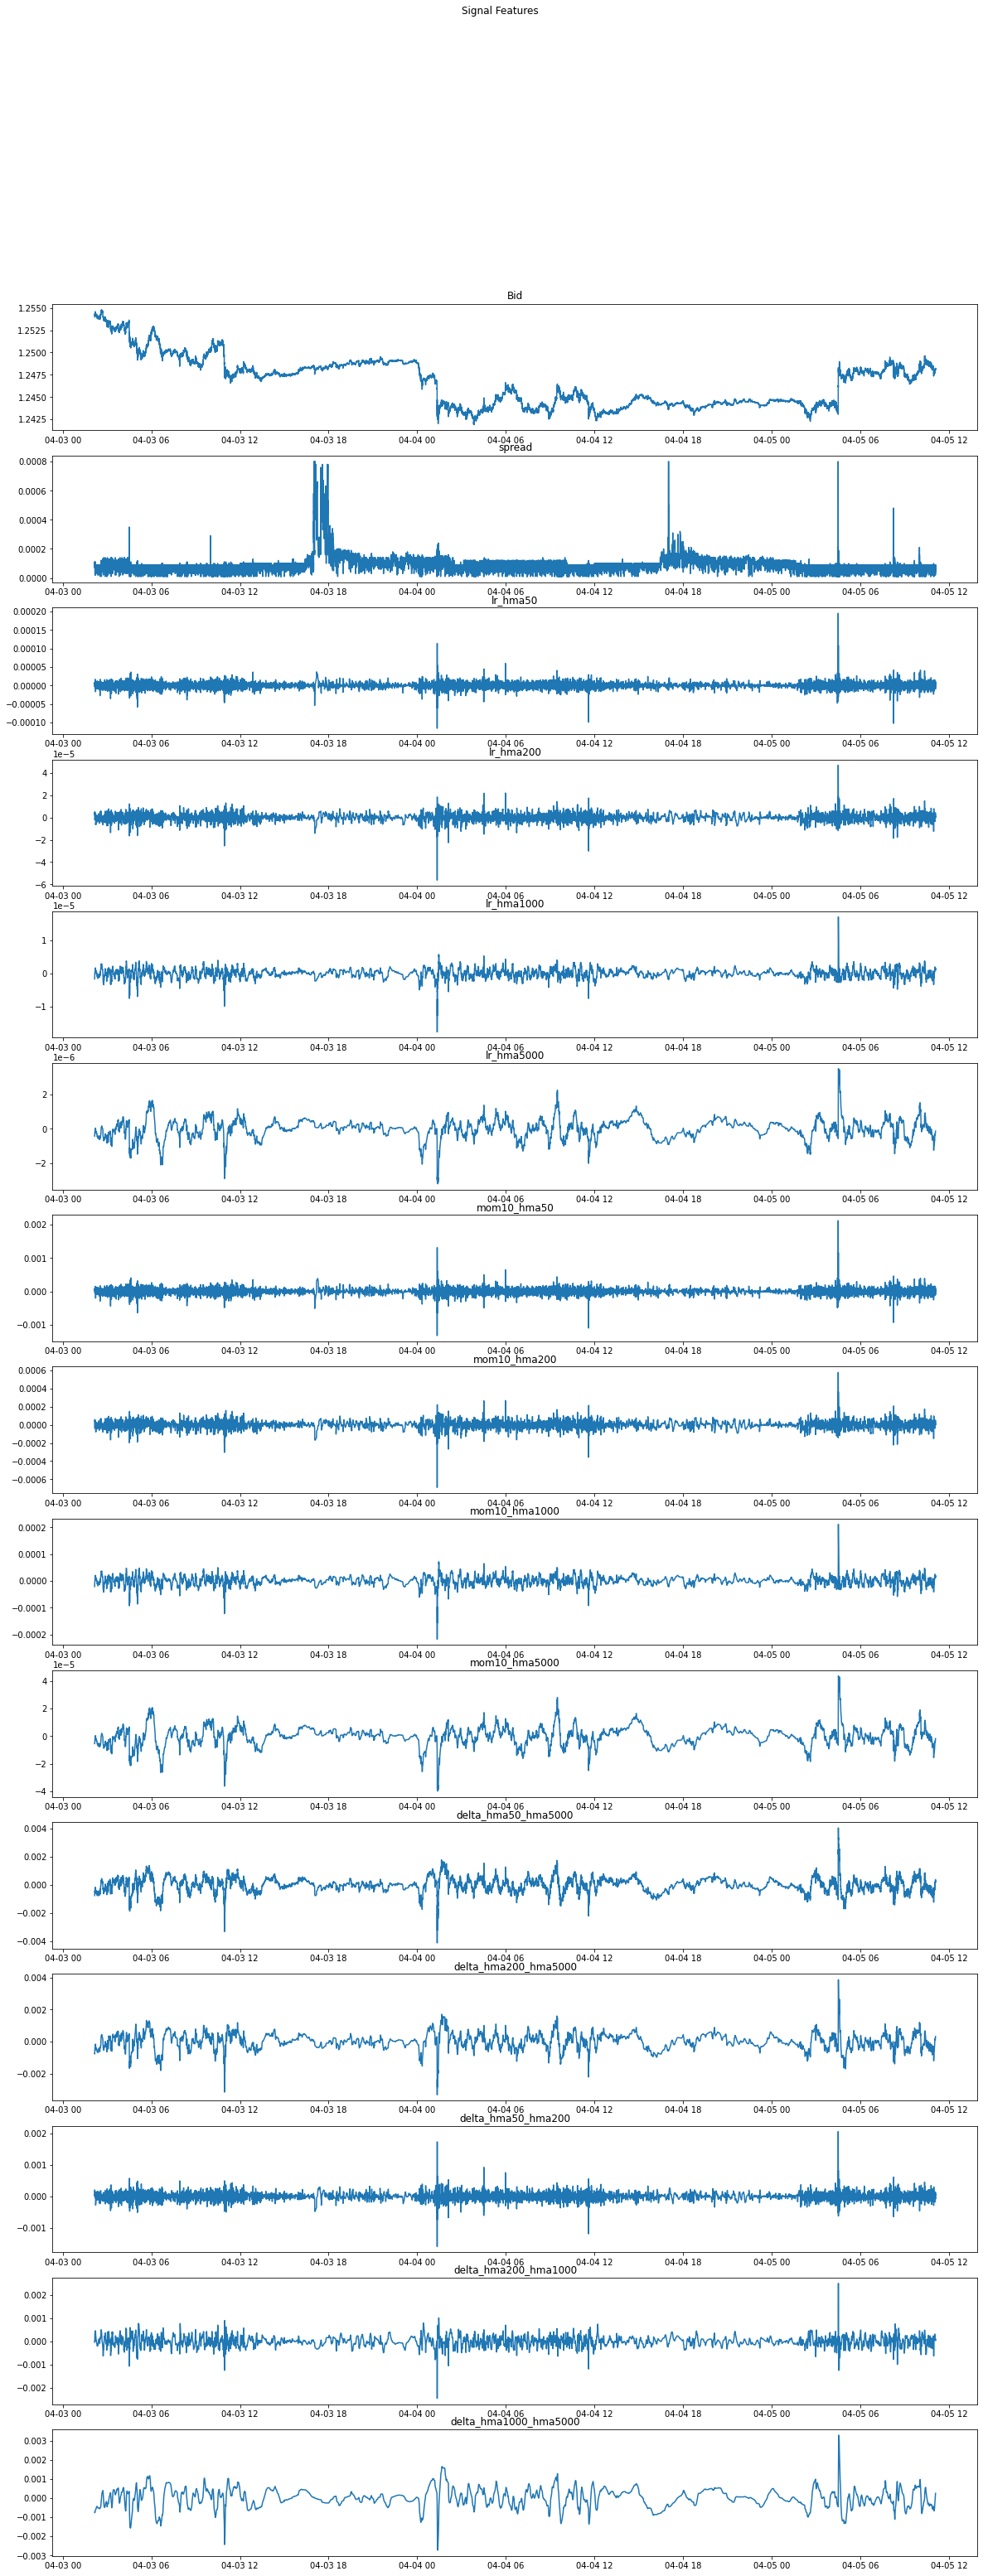

In [8]:
# plot 

rowsList = list(range(4000,146828))

fig, axs = plt.subplots(15, figsize=(20,50))
fig.suptitle('Signal Features')


axs[0].plot(df.bid.iloc[rowsList])
axs[0].set_title("Bid")
 
axs[1].plot(df.spread.iloc[rowsList])
axs[1].set_title("spread")

# log returns of ma's
axs[2].plot(df.lr_hma50.iloc[rowsList]) # this filters sufficiently, yet retains bid line shape with enough detail
axs[2].set_title("lr_hma50")
 
axs[3].plot(df.lr_hma200.iloc[rowsList])
axs[3].set_title("lr_hma200")
 
axs[4].plot(df.lr_hma1000.iloc[rowsList])
axs[4].set_title("lr_hma1000")
 
axs[5].plot(df.lr_hma5000.iloc[rowsList])
axs[5].set_title("lr_hma5000")

# MA momentums
axs[6].plot(df.mom10_hma50.iloc[rowsList])
axs[6].set_title("mom10_hma50")

axs[7].plot(df.mom10_hma200.iloc[rowsList])
axs[7].set_title("mom10_hma200")

axs[8].plot(df.mom10_hma1000.iloc[rowsList])
axs[8].set_title("mom10_hma1000")

axs[9].plot(df.mom10_hma5000.iloc[rowsList])
axs[9].set_title("mom10_hma5000")

# distance beteween ma's - take small period avg. minus large period => (+) is leading upwards
axs[10].plot(df.delta_hma50_hma5000.iloc[rowsList]) 
axs[10].set_title("delta_hma50_hma5000")

axs[11].plot(df.delta_hma200_hma5000.iloc[rowsList]) 
axs[11].set_title("delta_hma200_hma5000")


# adjacent ma's (neigbors by period)
axs[12].plot(df.delta_hma50_hma200.iloc[rowsList])
axs[12].set_title("delta_hma50_hma200")

axs[13].plot(df.delta_hma200_hma1000.iloc[rowsList])
axs[13].set_title("delta_hma200_hma1000")

axs[14].plot(df.delta_hma1000_hma5000.iloc[rowsList])
axs[14].set_title("delta_hma1000_hma5000")

'''
# Ratio of MA differences to largest difference (between the two extreme ma periods)
axs[15].plot(df.ratio_50delta200_tofullrange.iloc[rowsList])
axs[15].set_title("ratio_50delta200_tofullrange")

axs[16].plot(df.ratio_200delta1000_tofullrange.iloc[rowsList])
axs[16].set_title("ratio_200delta1000_tofullrange")

axs[17].plot(df.ratio_1000delta5000_tofullrange.iloc[rowsList])
axs[17].set_title("ratio_1000delta5000_tofullrange")
'''

In [9]:
# make deep copy 
features = (df[['spread','lr_hma50','lr_hma200','lr_hma1000','lr_hma5000','mom10_hma50','mom10_hma200','mom10_hma1000','mom10_hma5000','delta_hma50_hma5000','delta_hma50_hma200','delta_hma200_hma1000','delta_hma1000_hma5000','delta_hma200_hma5000']]).copy()

# Normalize features df
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

for col in features.columns:
    features[col] = min_max_scaling(features[col])

print('add bid ask to features')
features['bid'] = df.bid
features['ask'] = df.ask
print('Describe after normalization')
print('')
features.describe()



add bid ask to features
Describe after normalization



,spread,lr_hma50,lr_hma200,lr_hma1000,lr_hma5000,mom10_hma50,mom10_hma200,mom10_hma1000,mom10_hma5000,delta_hma50_hma5000,delta_hma50_hma200,delta_hma200_hma1000,delta_hma1000_hma5000,delta_hma200_hma5000,bid,ask
count,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06,1.171119e+06
mean,1.144303e-01,3.347798e-01,3.922079e-01,2.767760e-01,2.724970e-01,3.027027e-01,3.908185e-01,2.712099e-01,2.680640e-01,2.612658e-01,4.189445e-01,3.162611e-01,2.922516e-01,2.134072e-01,1.264334e+00,1.264434e+00
std,7.027129e-02,1.772838e-02,1.536453e-02,2.308086e-02,4.274704e-02,1.748650e-02,1.518062e-02,2.309721e-02,4.257969e-02,3.316753e-02,1.479271e-02,2.072248e-02,5.183538e-02,3.374466e-02,1.811841e-02,1.811550e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.236540e+00,1.236680e+00
25%,8.860759e-02,3.264555e-01,3.846171e-01,2.646535e-01,2.503276e-01,2.944330e-01,3.833356e-01,2.590970e-01,2.460192e-01,2.435936e-01,4.115827e-01,3.055538e-01,2.649700e-01,1.954717e-01,1.248310e+00,1.248400e+00
50%,1.012658e-01,3.347409e-01,3.921319e-01,2.765513e-01,2.717387e-01,3.026863e-01,3.907454e-01,2.709790e-01,2.672954e-01,2.612228e-01,4.189381e-01,3.161705e-01,2.918370e-01,2.134815e-01,1.256030e+00,1.256120e+00
75%,1.139241e-01,3.431285e-01,3.997639e-01,2.885298e-01,2.945594e-01,3.109856e-01,3.982678e-01,2.829347e-01,2.900154e-01,2.792514e-01,4.262408e-01,3.269351e-01,3.208571e-01,2.317189e-01,1.282020e+00,1.282110e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.296520e+00,1.296590e+00


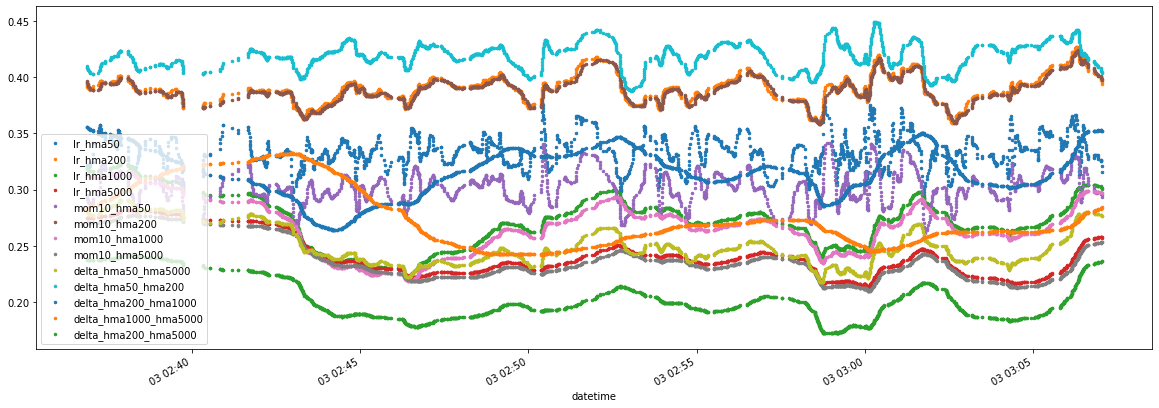

In [17]:
# examine data slices

rowsList = list(range(5000,6800))

sl = features.iloc[rowsList, [1,2,3,4,5,6,7,8,9,10,11,12,13] ]  #  4,5,6,14,  [15,16,17]  [0,3,4,5,6] [7,8,9,10]
#sl = df.iloc[rowsList, [7,8,9,10] ]  #  4,5,6,14,  [15,16,17],  [0,3,4,5,6], lr_'s [7,8,9,10]

# ploting parameters
mpl.rcParams['figure.figsize'] = (20, 7)     # set figure size 
mpl.rcParams['axes.grid'] = False

sl.plot(marker='.', linestyle='none', markersize=5)# ,linewidth=2, ) color='green', 

plt.show()

In [27]:
# make X Y for NEAT training
from numpy import empty

#features['outcome_asks'] = empty(len(features))
features['y'] = empty(len(features))

# make integer index
features['idx'] = np.arange(len(features))
features.set_index('idx') # THIS DIDN'T WORK !!!
# print(features.head())

# move size to detect for synthetic data
minimal_move = 0.0005 # 5 pips

# Synthesize Y labels as training data: find price breakout > minimal_move value
for idx in features.index:
    row = features.iloc[[idx]]
    innIdx = idx
    # loop from current index backward to find breakout direction (its reverse is label Y for training NN)
    while inrIdx > 0:
        #check if price broke minimal move. previous index is current index -1
        innIdx -= 1
        innRow = features.iloc[[innIdx]]
        # case: prices moved downwards more than minimal_move
        if (innRow.bid > row.bid + minimal_move):
            innRow.y = -1
        # case: prices oved upwards more than minimal_move
        if (innRow.bid < row.bid - minimal_move):
            innRow.y = 1
        

print('after:\n',features.head())

TypeError: ignored

In [ ]:
# graph outcomes for examination


In [ ]:
"""
2-input XOR example -- this is most likely the simplest possible example.
from: https://github.com/CodeReclaimers/neat-python/blob/master/examples/xor/evolve-minimal.py
"""

# 2-input XOR inputs and expected outputs.
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [(0.0,), (1.0,), (1.0,), (0.0,)]


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2


# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config-feedforward')

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

# Run until a solution is found.
winner = p.run(eval_genomes)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for xi, xo in zip(xor_inputs, xor_outputs):
    output = winner_net.activate(xi)
    outputRounded = round(output[0], 0)
    print("  input {!r}, expected output {!r}, got {!r}, rounded = {!r}".format(xi, xo, output, outputRounded))


 ****** Running generation 0 ****** 

Population's average fitness: 2.19354 stdev: 0.35020
Best fitness: 2.98963 - size: (1, 2) - species 1 - id 11
Average adjusted fitness: 0.537
Mean genetic distance 0.982, standard deviation 0.395
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 0.014 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.35397 stdev: 0.32104
Best fitness: 2.98963 - size: (1, 2) - species 1 - id 11
Average adjusted fitness: 0.533
Mean genetic distance 1.175, standard deviation 0.444
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 0.013 sec (0.014 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.30390 stdev: 0.35456
Best fitness: 2.99639 - size: (1, 2) - species 1 - id 360
Average adjusted fitness: 0.597
Mean genetic distance 1.310, standard deviation 0.442
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 0.017 sec (0.015 average)

